<a href="https://colab.research.google.com/github/abbasly/digit_classification/blob/master/MNIST_Hand_written_digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Hand-written digit classification



In [ ]:
from __future__ import print_function
from collections import namedtuple
from functools import partial

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.training import moving_averages

tf.logging.set_verbosity(tf.logging.ERROR)

## 1. Prepare the data
### <a href=http://yann.lecun.com/exdb/mnist/>MNIST dataset</a>
The MNIST has a training set of 55,000 examples, a validation set of 5,000 examples and a test set of 10,000 examples.

In [ ]:
mnist = input_data.read_data_sets('./data/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./data/t10k-labels-idx1-ubyte.gz


Load the training dataset

In [ ]:
train_images = mnist.train.images[:1000]
train_labels = mnist.train.labels[:1000]
train_images = train_images.reshape([-1, 28, 28, 1])

Load the validation sets

In [ ]:
val_images = mnist.validation.images
val_labels = mnist.validation.labels
val_images = val_images.reshape([-1, 28, 28, 1])

Plot the 1st hand-written digit and its one-hot label


One-hot labels for this image:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


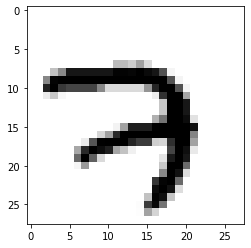

In [ ]:
plt.imshow(train_images[0,:,:,0], cmap='Greys')
print("\nOne-hot labels for this image:")
print(train_labels[0])

## 2. Build a graph for VGGNet (Oxford, 2014)
Very Deep Convolutional Networks for Large-scale image recognition
https://arxiv.org/abs/1409.1556

<img src="img/fig2.png">

### Set hyperparameters
- ***log_dir*** : Directory name to save models
- ***n_epochs*** : Maximun training epoch
- ***n_outputs*** : The number of classes for labels
- ***init_lr*** : Learning rate for gradient descent
- ***l2_lambda*** : regularization parameter
- ***batch_size*** : The number of images to update paramerters once

In [ ]:
log_dir = 'logs/'
n_epochs = 20
n_outputs = 10
init_lr = 0.01
batch_size = 100
l2_lambda = 0.0001

### Placeholder for learning rate, input images and labels

In [ ]:
lrn_rate = tf.placeholder(tf.float32, shape=(), name='lrn_rate')
images = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='images')
labels = tf.placeholder(tf.int32, shape=(None), name='labels')

In [ ]:
def vggnet(images, labels=None):
    vggnet_conv = partial(tf.layers.conv2d, kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_lambda), padding="SAME")
    
    ''' 1st conv. '''
    x1 = vggnet_conv(images, filters=16, kernel_size=7, strides=[1,1])  # 7x7 filter, # of filters: 16, stride: 1
    x1 = tf.layers.batch_normalization(x1, name='bn1')                   # batch normalization
    x1 = tf.nn.relu(x1)                                                  # ReLU activation
    
    ''' 2nd conv.'''
    x2 = vggnet_conv(x1, filters=16, kernel_size=3, strides=[1,1])       # 3x3 filter, # of filters: 16, stride 1
    x2 = tf.layers.batch_normalization(x2, name='bn2')                   # batch normalization
    x2 = tf.nn.relu(x2)                                                  # ReLU activation
    x2 = tf.layers.average_pooling2d(x2, pool_size=[2,2], strides=[2,2]) # 2x2 average pooling, stride: 2
    
    ''' 3rd conv. '''
    a = vggnet_conv(x1, filters=16, kernel_size=3, strides=[2, 2])      # 3x3 filter, # of filters: 16, stride: 2
    a = tf.layers.batch_normalization(a, name='bn3')                   # batch normalization
    a = tf.nn.relu(a)                                                  # ReLU activation
    
    x3 = tf.math.add(a,x2)

    x4 = x3

    x5 = vggnet_conv(x3, filters=16, kernel_size=3, strides=[1,1])       # 3x3 filter, # of filters: 16, stride: 1
    x5 = tf.layers.batch_normalization(x5, name='bn5')                   # batch normalization
    x5 = tf.nn.relu(x5)                                                  # ReLU activation
 

    x6 = tf.concat([x5, x4],3 )


    ''' 6th conv. '''
    x6 = vggnet_conv(x1, filters=32, kernel_size=3, strides=[1,1])       # 3x3 filter, # of filters: 32, stride: 1
    x6 = tf.layers.batch_normalization(x6, name='bn6')                   # batch normalization
    x6 = tf.nn.relu(x6)                                                  # ReLU activation
    
    img_feat = tf.reduce_mean(x6, [1, 2])                               # Global average pooling
    return img_feat

### Build a model

In [ ]:
global_step = tf.Variable(0, trainable=False)

with tf.variable_scope('embed') as scope:
#     feats = simple_network(images)
    feats = vggnet(images)

## Reshape
feats = tf.reshape(feats, [batch_size, 32])
    
## Logits
logits = tf.layers.dense(feats, n_outputs, kernel_initializer=tf.uniform_unit_scaling_initializer(factor=2.0), 
                                               kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_lambda))

## Evaluation
correct = tf.nn.in_top_k(logits, labels, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## SOFTMAX
preds = tf.nn.softmax(logits)

## Cost function
cent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cost_cls = tf.reduce_mean(cent, name='cent')

### L2 regularization

In [ ]:
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
cost = tf.add_n([cost_cls] + reg_losses)

### Momentum optimizer

In [ ]:
lr  = tf.train.exponential_decay(init_lr, global_step, 1000, 0.8, staircase = True) # learning rate decay
optimizer = tf.train.MomentumOptimizer(lr, 0.9, use_nesterov=True)                  # Momentum optimizer
train_op = optimizer.minimize(cost)

# 3. Train a model

### Create a session and initialize parameters
Tensorflow operations must be executed in the session.

In [ ]:
## MAKE SESSION
sess = tf.Session()

## INITIALIZE SESSION
sess.run(tf.global_variables_initializer())

### Updates parameters with back-propagation

In [ ]:
for epoch in range(n_epochs+1):
    for iteration in range(mnist.train.num_examples // batch_size):
        start_time = time.time()
        
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        X_batch = X_batch.reshape([-1, 28, 28, 1])
        (_, loss, loss_cls, prediction) = sess.run([train_op, cost, cost_cls, preds], 
                                                    feed_dict={images: X_batch, labels: y_batch})
        duration = time.time() - start_time
        sec_per_batch = float(duration)
    
    ## Training accuracy every one epoch
    acc_train = accuracy.eval(session=sess, feed_dict={images: X_batch, labels: np.argmax(y_batch, axis=1)})
    if epoch % 1 == 0:
        print('  [*] TRAINING Iteration %d, Loss: %.4f, Acc: %.4f (duration: %.3fs)'
                             % (epoch, loss_cls, acc_train, sec_per_batch))

    ## Validation accuracy every 5 epochs
    if epoch % 5 == 0:
        acc_val = accuracy.eval(session=sess, feed_dict={images: val_images, labels: np.argmax(val_labels, axis=1)})
        print('  [*] VALIDATION ACC: %.3f' % acc_val)

print('Optimization done.')

  [*] TRAINING Iteration 0, Loss: 1.8534, Acc: 0.3600 (duration: 0.161s)
  [*] VALIDATION ACC: 0.258
  [*] TRAINING Iteration 1, Loss: 1.5118, Acc: 0.5400 (duration: 0.168s)
  [*] TRAINING Iteration 2, Loss: 0.7992, Acc: 0.7700 (duration: 0.165s)
  [*] TRAINING Iteration 3, Loss: 0.3901, Acc: 0.8800 (duration: 0.164s)
  [*] TRAINING Iteration 4, Loss: 0.4139, Acc: 0.8800 (duration: 0.164s)
  [*] TRAINING Iteration 5, Loss: 0.2555, Acc: 0.9200 (duration: 0.167s)
  [*] VALIDATION ACC: 0.912
  [*] TRAINING Iteration 6, Loss: 0.5026, Acc: 0.8300 (duration: 0.166s)
  [*] TRAINING Iteration 7, Loss: 0.2297, Acc: 0.9200 (duration: 0.165s)
  [*] TRAINING Iteration 8, Loss: 0.1402, Acc: 0.9700 (duration: 0.167s)
  [*] TRAINING Iteration 9, Loss: 0.2759, Acc: 0.9200 (duration: 0.163s)
  [*] TRAINING Iteration 10, Loss: 0.3089, Acc: 0.9500 (duration: 0.166s)
  [*] VALIDATION ACC: 0.949
  [*] TRAINING Iteration 11, Loss: 0.1100, Acc: 0.9800 (duration: 0.163s)
  [*] TRAINING Iteration 12, Loss: 0.1

# 4. Test a model

### Load the test images and labels


One-hot labels for this image:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


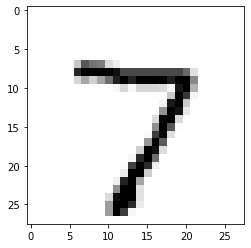

In [ ]:
## READ MNIST INPUTS
test_images = mnist.test.images
test_labels = mnist.test.labels
test_images = test_images.reshape([-1, 28, 28, 1])

## Plot the 1st test image and label
plt.imshow(test_images[0,:,:,0], cmap='Greys')
print("\nOne-hot labels for this image:")
print(test_labels[0])

### Check the prediction for the first image

In [ ]:
prediction = sess.run(preds, feed_dict={images: test_images[0,:,:,0].reshape(1,28,28,1), labels: test_labels[0]})

print("The prediction of the network is: %d" % np.argmax(prediction))

The prediction of the network is: 7


### Average the accuray for test set

In [ ]:
test_acc = accuracy.eval(session=sess, feed_dict={images: test_images, labels: np.argmax(test_labels, axis=1)})
print('Acc: %.3f' % test_acc)

Acc: 0.966
